<p style="font-size: 12pt">
    <b>Общая задача:</b> предсказать зарплату по резюме/вакансии на основе данных.
</p>
<p style="font-size: 12pt">
    <b>Подзадача:</b> отчистить поле <i>навыки</i> от мусора и обеспечить интерпретируемость вклада каждого навыка в зарплату для конкретной профессии.
</p>
<p style="font-size: 12pt">
    <b>Данные:</b> датасет <i>data_vacancies.csv</i>
    <ul>
        <li>Профессия</li>
        <li>График работы</li>
        <li>Локация</li>
        <li>Навыки</li>
    </ul>
</p>    
<p style="font-size: 12pt">
    <b>Бейзлайн:</b> преобразовать данные указанных полей в числовой/векторный вид, обучить модель линейной регрессии, метрика MAPE
</p>    

Рост размерности -> больше данных


**Что посмотреть:**
1. Уменьшить размерность (без work_skills), посмотреть, как изменится метрика
2. Сформировать пары слов
3. Tf-idf
4. Fasttext: посмотреть размерность для work_skills

# Установка и импортирование библиотек

In [2]:
%%capture
!pip install spacy
!python -m spacy download ru_core_news_sm
!pip install fasttext
!pip install razdel
!pip install pymorphy2

In [3]:
# подключение библиотек
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
import spacy
import gensim.models
import fasttext
import fasttext.util
import razdel
import pymorphy2
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Объявление функций

In [39]:
# функция, возвращает векторизированное предложение
def get_vector(model, sentence, vector_size=100):
    sentence_vector = []

    if len(sentence) == 0:
        # Пустые предложения заполним их одним  словом
        token_vector = np.zeros(vector_size)
        sentence_vector.append(token_vector)
    else:
        for token in sentence:
            try:
                token_vector = model.wv[token]
            except KeyError as e:
                print('here')
                # Случай неизвестного слова
                token_vector = np.zeros(vector_size)
            finally:
                sentence_vector.append(token_vector)

    return np.mean(sentence_vector, axis=0)

In [40]:
# функция, возвращает векторизированные выборки
def vectorize_train_test(model, X_train, X_test, vector_size=100):
    X_train_vectorized = np.zeros((X_train.shape[0], vector_size))
    for index, sentence in enumerate(X_train):
        X_train_vectorized[index] = get_vector(model, sentence, vector_size)

    X_test_vectorized = np.zeros((X_test.shape[0], vector_size))
    for index, sentence in enumerate(X_test):
        X_test_vectorized[index] = get_vector(model, sentence,  vector_size)

    return X_train_vectorized, X_test_vectorized

In [41]:
"""
Функция, считает:
 - среднюю вероятность схожести с соседом
 - среднее косинусное расстояние между схожими словами
"""
def calculate_metrics(model):
    words = model.wv.key_to_index.keys()
    mean_proba = 0
    mean_distance = 0

    for word in words:
        candidate = model.wv.most_similar(positive=[word], topn=1)[0]
        mean_distance += model.wv.distance(candidate[0], word)
        mean_proba += candidate[1]

    return mean_proba / len(words), mean_distance / len(words)

In [42]:
# функция, очистка от html разметки
def clean_html_bs4(text_data):
    soup = BeautifulSoup(text_data, 'lxml')
    return soup.get_text()

In [43]:
# функция, очистка от мусора, нормализация и лемматизация
def tokenize(text, stopwords, need_lemmatize=False):
    result = []
    sentences = [item.text for item in razdel.sentenize(str(text))]

    for sentence in sentences:
        text = sentence.lower()
        text = clean_html_bs4(text)
        text = re.sub(r"\s+", ' ', text)

        tokens = [item.text for item in  razdel.tokenize(text)]
        tokens = [re.sub("[^а-яА-Яa-zA-Z]", ' ', item) for item in tokens]

        if need_lemmatize:
            tokens = [analyzer.parse(token)[0].normal_form for token in tokens if token not in stopwords  and ' ' not in token and len(token) > 2]
            tokens = [token for token in tokens if token not in lemmatized_sw]
        tokens = [re.sub(r"ё", "е", token) for token in tokens]
        result.extend(tokens)
    return result

In [44]:
# функция получение сочетаний слов
def get_ngrams(texts_out):
    texts_out = [trigram[bigram[doc]] for doc in texts_out]
    return texts_out

# Загрузка датасета

In [12]:
df = pd.read_csv('/content/data_vacancies.csv')
df.head(5)

,id,custom_position,schedule,salary_from,salary_to,salary_pay_type,offer_education_id,education_name,education_is_base,education_order_num,city_id,list_regions,work_skills,tags_id
0,48202096,Сварщик-сборщик,полный рабочий день,60000,120000,NaN,0,любое,True,0,2,[4],"['сварочные работы', 'сборка изделий по чертеж...",NaN
1,48202097,Сварщик-монтажник,полный рабочий день,60000,120000,NaN,0,любое,True,0,2,[4],"['монтажные работы', 'строительные работы', 'э...",NaN
2,48202098,Слесарь-сборщик,полный рабочий день,60000,80000,NaN,0,любое,True,0,2,[4],"['работа на фрезерных станках', 'слесарный рем...",NaN
3,48202356,Грузчик-упаковщик,частичная занятость,30000,35000,NaN,0,любое,True,0,1,[3],"['комплектация товара', 'маркировка', 'стрессо...","[6, 9]"
4,48202357,Грузчик-упаковщик,частичная занятость,30000,35000,NaN,0,любое,True,0,57,"[181, 182, 183, 185, 186, 187, 188, 189, 190, ...","['маркировка', 'стрессоустойчивость', 'погрузо...","[6, 9]"


# Первичный анализ

Анализ по городам

Text(0.5, 1.0, 'Гистограмма education_name')

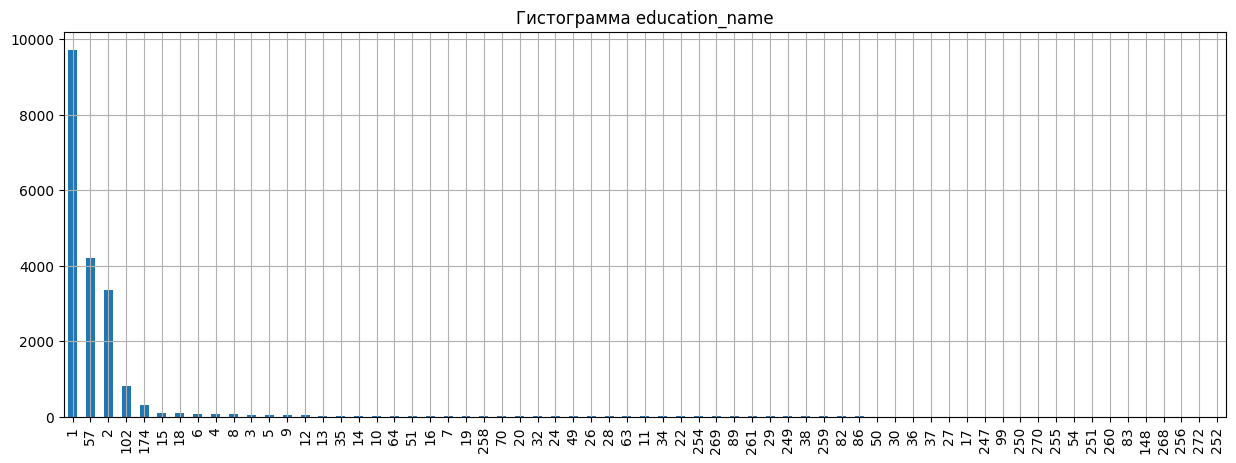

In [13]:
plt.figure(figsize=(15, 5))
df['city_id'].value_counts().plot(kind='bar', grid=True)
plt.title("Гистограмма education_name")

Корреляция



<ipython-input-14-6dc1c4c1753e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

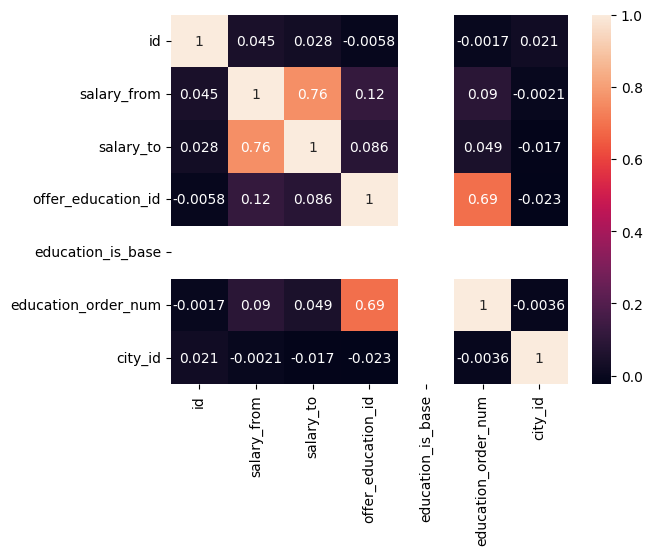

In [14]:
sns.heatmap(df.corr(), annot=True)

# Предобработка

## Выбор необходимых полей

In [15]:
df = df[['custom_position', 'schedule', 'salary_from', 'city_id', 'work_skills']]
df.head(5)

,custom_position,schedule,salary_from,city_id,work_skills
0,Сварщик-сборщик,полный рабочий день,60000,2,"['сварочные работы', 'сборка изделий по чертеж..."
1,Сварщик-монтажник,полный рабочий день,60000,2,"['монтажные работы', 'строительные работы', 'э..."
2,Слесарь-сборщик,полный рабочий день,60000,2,"['работа на фрезерных станках', 'слесарный рем..."
3,Грузчик-упаковщик,частичная занятость,30000,1,"['комплектация товара', 'маркировка', 'стрессо..."
4,Грузчик-упаковщик,частичная занятость,30000,57,"['маркировка', 'стрессоустойчивость', 'погрузо..."


## Вакансии для топ-5 локаций

In [16]:
top5_loc = df['city_id'].value_counts()[:5].index.tolist()
df = df[df['city_id'].isin(top5_loc)]
df.head(5)

,custom_position,schedule,salary_from,city_id,work_skills
0,Сварщик-сборщик,полный рабочий день,60000,2,"['сварочные работы', 'сборка изделий по чертеж..."
1,Сварщик-монтажник,полный рабочий день,60000,2,"['монтажные работы', 'строительные работы', 'э..."
2,Слесарь-сборщик,полный рабочий день,60000,2,"['работа на фрезерных станках', 'слесарный рем..."
3,Грузчик-упаковщик,частичная занятость,30000,1,"['комплектация товара', 'маркировка', 'стрессо..."
4,Грузчик-упаковщик,частичная занятость,30000,57,"['маркировка', 'стрессоустойчивость', 'погрузо..."


Проверка на пропуски

In [17]:
df.isna().sum()

custom_position    0
schedule           0
salary_from        0
city_id            0
work_skills        0
dtype: int64

### Уникальные значения:

- Графика работы

In [18]:
df['schedule'].unique()

array(['полный рабочий день', 'частичная занятость', 'сменный график',
       'свободный график', 'вахта', 'удаленная работа'], dtype=object)

- Городов

In [19]:
df['city_id'].unique()

array([  2,   1,  57, 102, 174])

### OneHotEncoding полей **city_id** и **schedule**

In [20]:
city_id_one = pd.get_dummies(df['city_id'], prefix='city_id')
schedule_one = pd.get_dummies(df['schedule'], prefix='schedule')

df = pd.concat([df, city_id_one], axis=1)
df = pd.concat([df, schedule_one], axis=1)

df.drop(columns=['city_id'], inplace=True)
df.drop(columns=['schedule'], inplace=True)
df.head(5)

,custom_position,salary_from,work_skills,city_id_1,city_id_2,city_id_57,city_id_102,city_id_174,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость
0,Сварщик-сборщик,60000,"['сварочные работы', 'сборка изделий по чертеж...",0,1,0,0,0,0,1,0,0,0,0
1,Сварщик-монтажник,60000,"['монтажные работы', 'строительные работы', 'э...",0,1,0,0,0,0,1,0,0,0,0
2,Слесарь-сборщик,60000,"['работа на фрезерных станках', 'слесарный рем...",0,1,0,0,0,0,1,0,0,0,0
3,Грузчик-упаковщик,30000,"['комплектация товара', 'маркировка', 'стрессо...",1,0,0,0,0,0,0,0,0,0,1
4,Грузчик-упаковщик,30000,"['маркировка', 'стрессоустойчивость', 'погрузо...",0,0,1,0,0,0,0,0,0,0,1


### Нормализация и токенизации поля **custom_position**

In [ ]:
!pip install spacy
!python -m spacy download ru_core_news_sm

In [27]:
nlp = spacy.load('ru_core_news_sm')

df['custom_position_clear'] = df['custom_position'].apply(
    lambda x: [str(token).lower() for token in nlp(x) if
      not token.is_stop
      and not token.is_punct
      and not token.is_digit
      and not token.like_email
      and not token.like_num
      and not token.is_space
    ]
  )

df.drop(columns=['custom_position'], inplace=True)
df.head(5)

,salary_from,work_skills,city_id_1,city_id_2,city_id_57,city_id_102,city_id_174,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость,custom_position_clear
0,60000,"['сварочные работы', 'сборка изделий по чертеж...",0,1,0,0,0,0,1,0,0,0,0,"[сварщик, сборщик]"
1,60000,"['монтажные работы', 'строительные работы', 'э...",0,1,0,0,0,0,1,0,0,0,0,"[сварщик, монтажник]"
2,60000,"['работа на фрезерных станках', 'слесарный рем...",0,1,0,0,0,0,1,0,0,0,0,"[слесарь, сборщик]"
3,30000,"['комплектация товара', 'маркировка', 'стрессо...",1,0,0,0,0,0,0,0,0,0,1,"[грузчик, упаковщик]"
4,30000,"['маркировка', 'стрессоустойчивость', 'погрузо...",0,0,1,0,0,0,0,0,0,0,1,"[грузчик, упаковщик]"


# **Векторизация предложений**

## Обработка custom_position:
 - Исследование обучения для FastText

In [35]:
pd.DataFrame([[0.374, 0.33], [0.386, 0.318], [0.264, 0.283]],
             columns=['Без предобученного Fasttext', 'Предобученный Fasttext'],
             index=['R2_train', 'R2_test', 'MAPE'])

,Без предобученного Fasttext,Предобученный Fasttext
R2_train,0.374,0.330
R2_test,0.386,0.318
MAPE,0.264,0.283


### Удаление колонки со скилами - **work_skills**

In [36]:
df_temp = df.drop(columns=['work_skills'])
df_temp.head(5)

,salary_from,city_id_1,city_id_2,city_id_57,city_id_102,city_id_174,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость,custom_position_clear
0,60000,0,1,0,0,0,0,1,0,0,0,0,"[сварщик, сборщик]"
1,60000,0,1,0,0,0,0,1,0,0,0,0,"[сварщик, монтажник]"
2,60000,0,1,0,0,0,0,1,0,0,0,0,"[слесарь, сборщик]"
3,30000,1,0,0,0,0,0,0,0,0,0,1,"[грузчик, упаковщик]"
4,30000,0,0,1,0,0,0,0,0,0,0,1,"[грузчик, упаковщик]"


### Создание обучающей и проверочной выборок
- Без колонки - **work_skills**

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_temp.loc[:, df_temp.columns != 'salary_from'],
                                                    df['salary_from'], random_state=2023)

## Обучение **fasttext**

In [45]:
mapes = []
r2_scores = []
mean_probas = []
mean_distances = []

for epochs in tqdm(range(5, 110, 5)):
    # обучение fasttext
    fasttext = gensim.models.FastText(vector_size=100, min_count=1)
    fasttext.build_vocab(corpus_iterable=X_train['custom_position_clear'])

    fasttext.train(
        corpus_iterable=X_train['custom_position_clear'],
        total_examples=len(X_train['custom_position_clear']),
        epochs=epochs
        )

    # получение embeddings
    cuspos_vec_train, cuspos_vec_test = vectorize_train_test(fasttext, X_train['custom_position_clear'],
                                                                       X_test['custom_position_clear'])

    cuspos_vec_train = pd.DataFrame(cuspos_vec_train).add_prefix('custom_position_')
    cuspos_vec_test = pd.DataFrame(cuspos_vec_test).add_prefix('custom_position_')

    # формирование таблицы
    X_train_temp = pd.concat([X_train.reset_index(drop=True), cuspos_vec_train], axis=1)
    X_test_temp = pd.concat([X_test.reset_index(drop=True), cuspos_vec_test], axis=1)

    X_train_temp.drop(columns=['custom_position_clear'], inplace=True)
    X_test_temp.drop(columns=['custom_position_clear'], inplace=True)

    # расчет метрик
    reg = LinearRegression().fit(X_train_temp, y_train)
    y_pred = reg.predict(X_test_temp)
    mean_proba, mean_distance = calculate_metrics(fasttext)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    mapes.append(mape)
    mean_probas.append(mean_proba)
    mean_distances.append(mean_distance)
    r2_scores.append(reg.score(X_test_temp, y_test))

  0%|          | 0/21 [00:00<?, ?it/s]

### Вывод графиков

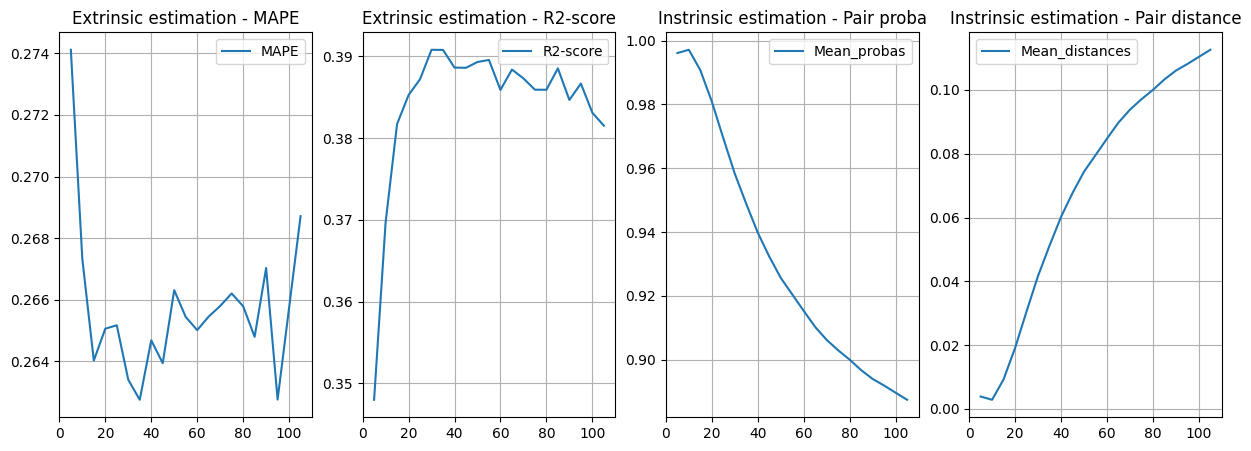

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].plot(np.arange(5, 110, 5), mapes, label='MAPE') # extrinsic
ax[1].plot(np.arange(5, 110, 5), r2_scores, label='R2-score') # intrinsic
ax[2].plot(np.arange(5, 110, 5), mean_probas, label='Mean_probas') # intrinsic
ax[3].plot(np.arange(5, 110, 5), mean_distances, label='Mean_distances') # intrinsic

ax[0].set_title("Extrinsic estimation - MAPE")
ax[1].set_title("Extrinsic estimation - R2-score")
ax[2].set_title("Instrinsic estimation - Pair proba")
ax[3].set_title("Instrinsic estimation - Pair distance")

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

#  Итоговый вариант обучения
- Вместе с колонкой **work_skills**

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'salary_from'],
                                                    df['salary_from'], random_state=2023)

In [48]:
fasttext = gensim.models.FastText(vector_size=100, min_count=1)
fasttext.build_vocab(corpus_iterable=X_train['custom_position_clear'])

fasttext.train(
    corpus_iterable=X_train['custom_position_clear'],
    total_examples=len(X_train['custom_position_clear']),
    epochs=20
    )


cuspos_vec_train, cuspos_vec_test = vectorize_train_test(fasttext,
                                                         X_train['custom_position_clear'],
                                                         X_test['custom_position_clear'])

cuspos_vec_train = pd.DataFrame(cuspos_vec_train).add_prefix('custom_position_')
cuspos_vec_test = pd.DataFrame(cuspos_vec_test).add_prefix('custom_position_')

X_train = pd.concat([X_train.reset_index(drop=True), cuspos_vec_train], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), cuspos_vec_test], axis=1)

X_train.drop(columns=['custom_position_clear'], inplace=True)
X_test.drop(columns=['custom_position_clear'], inplace=True)

## Результат обучения

In [49]:
X_train.head(5)

,work_skills,city_id_1,city_id_2,city_id_57,city_id_102,city_id_174,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,...,custom_position_90,custom_position_91,custom_position_92,custom_position_93,custom_position_94,custom_position_95,custom_position_96,custom_position_97,custom_position_98,custom_position_99
0,"['ведение клиентской базы', 'пунктуальность', ...",1,0,0,0,0,0,1,0,0,...,0.522202,0.285944,-0.782569,-0.175200,0.501254,0.964078,0.627550,0.208026,0.948243,-0.471997
1,"['редактирование', 'рерайтинг', 'написание тек...",1,0,0,0,0,0,0,0,0,...,0.648099,-0.071965,-0.459824,-0.980841,0.395445,1.030961,0.328562,0.416538,0.935069,-0.622044
2,"['перевозка пассажиров', 'безаварийное вождени...",0,1,0,0,0,0,0,1,0,...,0.644740,-0.623109,-0.210037,-0.133063,0.061045,0.718483,0.374509,-0.197701,0.347320,-0.645513
3,"['сдача отчетности', 'расчет заработной платы'...",0,1,0,0,0,0,1,0,0,...,0.368217,-0.303556,-0.384230,-0.409774,0.466701,1.041069,0.423931,0.253462,0.297029,-0.734313
4,"['общение с клиентами', 'продажи продукта / ус...",1,0,0,0,0,0,1,0,0,...,0.416270,0.145728,-0.575196,-0.043978,0.254284,0.731245,0.477595,0.300301,0.661834,-0.323321


# Обработка work_skills - **TF-IDF**

Создание **X_train** и **X_test** через итерацию строк - **.iterrows**

In [50]:
for index, row in X_train.iterrows():
    X_train['work_skills'][index] = " ".join([word.replace('\'', '')
                                for word in row['work_skills'].split('[')[1].split(']')[0].split(', ')])

for index, row in X_test.iterrows():
    X_test['work_skills'][index] = " ".join([word.replace('\'', '')
                                for word in row['work_skills'].split('[')[1].split(']')[0].split(', ')])

<ipython-input-50-656206932870>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['work_skills'][index] = " ".join([word.replace('\'', '')
<ipython-input-50-656206932870>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['work_skills'][index] = " ".join([word.replace('\'', '')


Проверка результата

In [52]:
# В массиве
X_train['work_skills'][0]

'ведение клиентской базы пунктуальность обучаемость сопровождение сделки умение продавать грамотная речь выполнение плана продаж активные продажи продажи стрессоустойчивость CRM-система'

## Инициализация **стоп-слов**

In [53]:
sw = stopwords.words('russian')
additional_sw =  'мои оно мной мною мог могут мор мое мочь оба нам нами ними однако нему никуда наш нею неё наша наше наши очень отсюда вон вами ваш ваша ваше ваши весь всем всеми вся ими ею будем будете будешь буду будь будут кому кого которой которого которая которые который которых кем каждое каждая каждые каждый кажется та те тому собой тобой собою тобою тою хотеть хочешь свое свои твой своей своего своих твоя твоё сама сами теми само самом самому самой самого самим самими самих саму чему тебе такое такие также такая сих тех ту эта это этому туда этим этими этих абы аж ан благо буде вроде дабы едва ежели затем зато ибо итак кабы коли коль либо лишь нежели пока покамест покуда поскольку притом причем пускай пусть ровно сиречь словно также точно хотя чисто якобы '
pronouns = 'я мы ты вы он она оно они себя мой твой ваш наш свой его ее их то это тот этот такой таков столько весь всякий сам самый каждый любой иной другой кто что какой каков чей сколько никто ничто некого нечего никакой ничей нисколько кто-то кое-кто кто-нибудь кто-либо что-то кое-что что-нибудь что-либо какой-то какой-либо какой-нибудь некто нечто некоторый некий'
conjunctions = 'что чтобы как когда ибо пока будто словно если потому что оттого что так как так что лишь только как будто с тех пор как в связи с тем что для того чтобы кто как когда который какой где куда откуда'
digits = 'ноль один два три четыре пять шесть семь восемь девять десять одиннадцать двенадцать тринадцать четырнадцать пятнадцать шестнадцать семнадцать восемнадцать девятнадцать двадцать тридцать сорок пятьдесят шестьдесят семьдесят восемьдесят девяносто сто'
modal_words = 'вероятно возможно видимо по-видимому кажется наверное безусловно верно  действительно конечно несомненно разумеется'
particles = 'да так точно ну да не ни неужели ли разве а что ли что за то-то как ну и ведь даже еще ведь уже все все-таки просто прямо вон это вот как словно будто точно как будто вроде как бы именно как раз подлинно ровно лишь только хоть всего исключительно вряд ли едва ли'
prepositions = 'близ  вблизи  вдоль  вокруг  впереди  внутрь  внутри  возле  около  поверх  сверху  сверх  позади  сзади  сквозь  среди  прежде  мимо  вслед  согласно  подобно  навстречу  против  напротив  вопреки  после  кроме  вместе  вдали  наряду  совместно  согласно  нежели вроде от бишь до без аж тех раньше совсем только итак например из прямо ли следствие а поскольку благо пускай благодаря случае затем притом также связи время при чтоб просто того невзирая даром вместо точно покуда тогда зато ради ан буде прежде насчет раз причине тому так даже исходя коль кабы более ровно либо помимо как-то будто если словно лишь бы и не будь пор тоже разве чуть как хотя наряду потому пусть в равно между сверх ибо на судя то чтобы относительно или счет за но сравнению причем оттого есть когда уж ввиду тем для дабы чем хоть с вплоть скоро едва после той да вопреки ежели кроме сиречь же коли под абы несмотря все пока покамест паче прямо-таки перед что по вдруг якобы подобно'
evaluative = 'наиболее наименее лучший больший высший низший худший более менее'

sw.extend(additional_sw.split())
sw.extend(pronouns.split())
sw.extend(conjunctions.split())
sw.extend(digits.split())
sw.extend(modal_words.split())
sw.extend(particles.split())
sw.extend(prepositions.split())
sw.extend(evaluative.split())
sw = list(set(sw))

## Морфологический анализ

In [ ]:
need_preprocess = True

if need_preprocess:
    analyzer = pymorphy2.MorphAnalyzer()
    lemmatized_sw = [analyzer.parse(word)[0].normal_form for word in sw]

    for index, row in X_train.iterrows():
        X_train['work_skills'][index] = tokenize(row['work_skills'], stopwords=sw, need_lemmatize=True)
    for index, row in X_test.iterrows():
        X_test['work_skills'][index] = tokenize(row['work_skills'], stopwords=sw, need_lemmatize=True)

### Результат - первой вакансии

In [56]:
# После обработки
X_train['work_skills'][0]

['ведение',
 'клиентский',
 'база',
 'пунктуальность',
 'обучаемость',
 'сопровождение',
 'сделка',
 'умение',
 'продавать',
 'грамотный',
 'речь',
 'выполнение',
 'план',
 'продажа',
 'активный',
 'продажа',
 'продажа',
 'стрессоустойчивость']

## Создание биграмм и триграмм:
- **Биграмма** — группа из двух слов.
- **Триграмма** — группа из трех слов.

In [57]:
bigram = gensim.models.Phrases(X_train['work_skills'], min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[X_train['work_skills']], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Получение сочетаний слов
- С помощью самописной функции - **get_ngrams()**

In [58]:
# функция получение сочетаний слов
def get_ngrams(texts_out):
    texts_out = [trigram[bigram[doc]] for doc in texts_out]
    return texts_out

In [ ]:
sentences_train = get_ngrams(X_train['work_skills'])
sentences_test = get_ngrams(X_test['work_skills'])

for index in range(len(sentences_train)):
    X_train['work_skills'][index] = sentences_train[index]

for index in range(len(sentences_test)):
    X_test['work_skills'][index] = sentences_test[index]

### Проверка результа

In [60]:
for i in range(50):
    print(X_train['work_skills'][i])

['ведение', 'клиентский', 'база', 'пунктуальность', 'обучаемость', 'сопровождение', 'сделка', 'умение', 'продавать', 'грамотный', 'речь', 'выполнение', 'план', 'продажа', 'активный', 'продажа', 'продажа', 'стрессоустойчивость']
['редактирование', 'рерайтинг', 'написание', 'текст', 'копирайтинг', 'редактирование', 'текст']
['перевозка', 'пассажир', 'безаварийный', 'вождение', 'спокойный', 'стиль', 'вождение']
['сдача', 'отчетность', 'расчет', 'заработный_плата', 'осный', 'усный']
['общение', 'клиент', 'продажа', 'продукт', 'услуга', 'техника', 'продажа', 'активный', 'продажа', 'обучаемость']
['работа', 'касса', 'работа', 'клиент', 'пунктуальность', 'работа', 'касса', 'ответственность', 'вежливость']
['качественный', 'уборка', 'уборка', 'помещение', 'ответственность', 'исполнительность', 'сухой', 'влажный', 'уборка', 'поддержание', 'чистота', 'порядок', 'выполнение', 'поставить', 'задача', 'порядочность', 'мытье', 'пол']
['приготовление', 'пища', 'влажный', 'уборка', 'генеральный', 'убор

## Замена **скилов** в обучающей и тестовой выборке

In [ ]:
for index, row in X_train.iterrows():
    X_train['work_skills'][index] = " ".join(row['work_skills'])

for index, row in X_test.iterrows():
    X_test['work_skills'][index] = " ".join(row['work_skills'])

In [62]:
for i in range(50):
    print(X_train['work_skills'][i])

ведение клиентский база пунктуальность обучаемость сопровождение сделка умение продавать грамотный речь выполнение план продажа активный продажа продажа стрессоустойчивость
редактирование рерайтинг написание текст копирайтинг редактирование текст
перевозка пассажир безаварийный вождение спокойный стиль вождение
сдача отчетность расчет заработный_плата осный усный
общение клиент продажа продукт услуга техника продажа активный продажа обучаемость
работа касса работа клиент пунктуальность работа касса ответственность вежливость
качественный уборка уборка помещение ответственность исполнительность сухой влажный уборка поддержание чистота порядок выполнение поставить задача порядочность мытье пол
приготовление пища влажный уборка генеральный уборка уход мебель смена_постельный_белье глажка одежда современный_бытовой техника уход vip_гардероб уход гардероб сухой влажный уборка пунктуальность уход гардероб уборка стирка глажка мытье окно
доброжелательность опыт
поддержание клиентский база общ

# **Tf-idf**

In [63]:
vectorizer = TfidfVectorizer(min_df=0.003, token_pattern=r'(?u)\b\w\w+\b')
ws_vec_train = vectorizer.fit_transform(X_train['work_skills'])
ws_vec_test = vectorizer.transform(X_test['work_skills'])

ws_vec_train = pd.DataFrame(ws_vec_train.toarray(), columns=vectorizer.get_feature_names_out()).add_prefix('ws_')
ws_vec_test = pd.DataFrame(ws_vec_test.toarray(), columns=vectorizer.get_feature_names_out()).add_prefix('ws_')

X_train = pd.concat([X_train.reset_index(drop=True), ws_vec_train], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), ws_vec_test], axis=1)

# X_train.drop(columns=['work_skills'], inplace=True)
# X_test.drop(columns=['work_skills'], inplace=True)

## Результат

In [64]:
X_train.head(5)

,work_skills,city_id_1,city_id_2,city_id_57,city_id_102,city_id_174,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,...,ws_чистота,ws_чтение,ws_шиномонтаж,ws_экспедирование,ws_эксплуатация,ws_электрика,ws_электроинструмент,ws_электромонтажный,ws_электрооборудование,ws_электросхема
0,ведение клиентский база пунктуальность обучаем...,1,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,редактирование рерайтинг написание текст копир...,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,перевозка пассажир безаварийный вождение споко...,0,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,сдача отчетность расчет заработный_плата осный...,0,1,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,общение клиент продажа продукт услуга техника ...,1,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Уаление столбца work_skills и создание:
- train
- test

In [65]:
train = X_train.drop(columns=['work_skills'])
test = X_test.drop(columns=['work_skills'])

# Линейная регрессия

In [66]:
reg = LinearRegression().fit(train, y_train)
y_pred = reg.predict(test)
r2_score = reg.score(test, y_test)
mape = mean_absolute_percentage_error(y_test, y_pred)

## Результат

In [67]:
print('r2_score:', r2_score)
print('mape:', mape)

r2_score: -114732842322967.48
mape: 38579.097317641186


# Усеченное сингулярное разложение и латентно — семантический анализ

**TruncatedSVD** - реализует вариант разложения по сингулярным значениям (**SVD**), который вычисляет только **k** наибольшие сингулярные значения, где **k** — параметр, задаваемый пользователем.

In [68]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np

svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)
train_test = svd.fit_transform(train)
test_test = svd.transform(test)

In [69]:
reg = LinearRegression().fit(train_test, y_train)
y_pred = reg.predict(test_test)
r2_score = reg.score(test_test, y_test)
mape = mean_absolute_percentage_error(y_test, y_pred)

## Результат

In [70]:
print('r2_score:', r2_score)
print('mape:', mape)

r2_score: 0.36817440144882385
mape: 0.2647235222949004


# Обработка work_skills - **FastText**.

In [ ]:
for index, row in X_train.iterrows():
    X_train['work_skills'][index] = " ".join([word.replace('\'', '')
                                for word in row['work_skills'].split('[')[1].split(']')[0].split(', ')])

for index, row in X_test.iterrows():
    X_test['work_skills'][index] = " ".join([word.replace('\'', '')
                                for word in row['work_skills'].split('[')[1].split(']')[0].split(', ')])

<ipython-input-389-26c90bfa41ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['work_skills'][index] = " ".join([word.replace('\'', '')
<ipython-input-389-26c90bfa41ad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['work_skills'][index] = " ".join([word.replace('\'', '')


## Морфологический анализ

In [73]:
need_preprocess = True

if need_preprocess:
    analyzer = pymorphy2.MorphAnalyzer()
    lemmatized_sw = [analyzer.parse(word)[0].normal_form for word in sw]

    for index, row in X_train.iterrows():
        X_train['work_skills'][index] = tokenize(row['work_skills'], stopwords=sw, need_lemmatize=True)
    for index, row in X_test.iterrows():
        X_test['work_skills'][index] = tokenize(row['work_skills'], stopwords=sw, need_lemmatize=True)

<ipython-input-73-2462b0f2801e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['work_skills'][index] = tokenize(row['work_skills'], stopwords=sw, need_lemmatize=True)
<ipython-input-73-2462b0f2801e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['work_skills'][index] = tokenize(row['work_skills'], stopwords=sw, need_lemmatize=True)


## Создание биграмм и триграмм:
- **Биграмма** — группа из двух слов.
- **Триграмма** — группа из трех слов.

In [74]:
bigram = gensim.models.Phrases(X_train['work_skills'], min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[X_train['work_skills']], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Получение сочетаний слов
- С помощью самописной функции - **get_ngrams()**

In [75]:
sentences_train = get_ngrams(X_train['work_skills'])
sentences_test = get_ngrams(X_test['work_skills'])

for index in range(len(sentences_train)):
    X_train['work_skills'][index] = sentences_train[index]

for index in range(len(sentences_test)):
    X_test['work_skills'][index] = sentences_test[index]

<ipython-input-75-317ce699dac0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['work_skills'][index] = sentences_train[index]
<ipython-input-75-317ce699dac0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['work_skills'][index] = sentences_test[index]


## Обучение **fasttext**

In [76]:
mapes = []
r2_scores = []
mean_probas = []
mean_distances = []

for size in tqdm(range(50, 1000, 50)):
    # обучение fasttext
    fasttext = gensim.models.FastText(vector_size=size, min_count=1)
    fasttext.build_vocab(corpus_iterable=X_train['work_skills'])

    fasttext.train(
        corpus_iterable=X_train['work_skills'],
        total_examples=len(X_train['work_skills']),
        epochs=20
        )

    # получение embeddings
    ws_vec_train, ws_vec_test = vectorize_train_test(fasttext, X_train['work_skills'],
                                                               X_test['work_skills'], vector_size=size)

    ws_vec_train = pd.DataFrame(ws_vec_train).add_prefix('ws_')
    ws_vec_test = pd.DataFrame(ws_vec_test).add_prefix('ws_')

    # формирование таблицы
    X_train_temp = pd.concat([X_train.reset_index(drop=True), ws_vec_train], axis=1)
    X_test_temp = pd.concat([X_test.reset_index(drop=True), ws_vec_test], axis=1)

    X_train_temp.drop(columns=['work_skills'], inplace=True)
    X_test_temp.drop(columns=['work_skills'], inplace=True)

    # расчет метрик
    reg = LinearRegression().fit(X_train_temp, y_train)
    y_pred = reg.predict(X_test_temp)
    mean_proba, mean_distance = calculate_metrics(fasttext)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    mapes.append(mape)
    mean_probas.append(mean_proba)
    mean_distances.append(mean_distance)
    r2_scores.append(reg.score(X_test_temp, y_test))

  0%|          | 0/19 [00:00<?, ?it/s]

### Вывод графиков

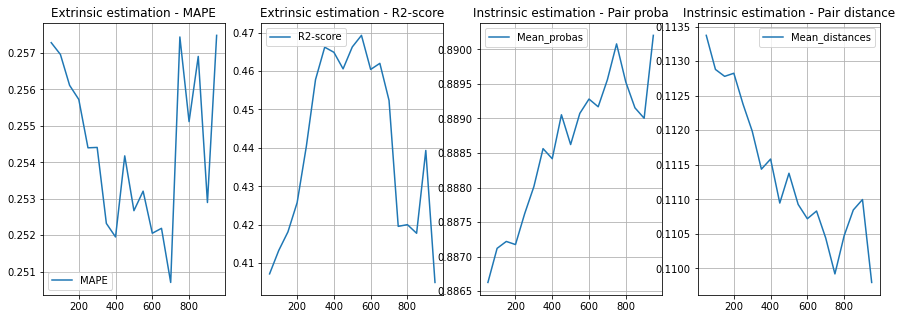

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].plot(np.arange(50, 1000, 50), mapes, label='MAPE') # extrinsic
ax[1].plot(np.arange(50, 1000, 50), r2_scores, label='R2-score') # intrinsic
ax[2].plot(np.arange(50, 1000, 50), mean_probas, label='Mean_probas') # intrinsic
ax[3].plot(np.arange(50, 1000, 50), mean_distances, label='Mean_distances') # intrinsic

ax[0].set_title("Extrinsic estimation - MAPE")
ax[1].set_title("Extrinsic estimation - R2-score")
ax[2].set_title("Instrinsic estimation - Pair proba")
ax[3].set_title("Instrinsic estimation - Pair distance")

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

## Результат

In [ ]:
sizes = np.arange(50, 1000, 50)
mapes = np.array(mapes)
r2_scores = np.array(r2_scores)
mean_probas = np.array(mean_probas)
mean_distances = np.array(mean_distances)

print("MAPE:", min(mapes), "Size:", sizes[np.argmin(mapes)])
print("R2:", max(r2_scores), "Size:", sizes[np.argmax(r2_scores)])
print("Proba:", max(mean_probas), "Size:", sizes[np.argmax(mean_probas)])
print("Distance:", min(mean_distances), "Size:", sizes[np.argmin(mean_distances)])

MAPE: 0.25070426504880505 Size: 700
R2: 0.4692807176882626 Size: 550
Proba: 0.890204315913995 Size: 950
Distance: 0.10979568653567466 Size: 950


# **2. KNN**

In [4]:
import ast

import pandas as pd
import numpy as np

import fasttext

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (mean_absolute_percentage_error,
                             mean_squared_error, r2_score)
from sklearn.neighbors import NearestNeighbors

from sklearn.linear_model import Ridge

# Предобработка

In [6]:
dataset = pd.read_csv('/content/data_vacancies.csv')

## Выбор необходимых полей

In [9]:
df = dataset[[
    'city_id',
    'custom_position',
    'schedule',
    'salary_from',
    'salary_to',
    'education_name',
    'work_skills'
    ]]

## Вакансии для топ-5 локаций

In [10]:
top5_cityids = df.city_id.value_counts(normalize=True).nlargest(5).keys()
df = df[df.city_id.isin(top5_cityids)]
df = df.reset_index().drop('index', axis=1)
df.work_skills = df.work_skills.apply(ast.literal_eval)
df

,city_id,custom_position,schedule,salary_from,salary_to,education_name,work_skills
0,2,Сварщик-сборщик,полный рабочий день,60000,120000,любое,"[сварочные работы, сборка изделий по чертежам,..."
1,2,Сварщик-монтажник,полный рабочий день,60000,120000,любое,"[монтажные работы, строительные работы, электр..."
2,2,Слесарь-сборщик,полный рабочий день,60000,80000,любое,"[работа на фрезерных станках, слесарный ремонт..."
3,1,Грузчик-упаковщик,частичная занятость,30000,35000,любое,"[комплектация товара, маркировка, стрессоустой..."
4,57,Грузчик-упаковщик,частичная занятость,30000,35000,любое,"[маркировка, стрессоустойчивость, погрузочно-р..."
...,...,...,...,...,...,...,...
18410,1,Кладовщик,полный рабочий день,45000,70000,среднее профессиональное,"[комплектация заказов, работа с документацией,..."
18411,1,Кассир,сменный график,35000,58000,любое,"[ответственность, контроль срока годности, раб..."
18412,1,Инженер по медицинской технике,полный рабочий день,77000,77000,высшее,"[уверенный пользователь ПК, ремонт оборудовани..."
18413,2,Автомеханик-автослесарь,полный рабочий день,80000,120000,любое,"[устройство автомобилей, ремонт тормозной сист..."


Видно, что мы теряем всего примерно **5%** датасета. Думаю на этапе бейзлайна нас это устраивает.

## Результат топ-20

In [11]:
df.custom_position.value_counts().nlargest(20)

Продавец-кассир                    409
Менеджер по продажам               283
Продавец-консультант               238
Курьер                             193
Охранник                           134
Повар                              130
Разнорабочий                       127
Водитель по доставке документов    118
Грузчик                            118
Комплектовщик                      112
Работник торгового зала            105
Продавец                            96
Менеджер по работе с клиентами      95
Кладовщик                           95
Мерчандайзер-грузчик                94
Водитель-экспедитор                 87
Оператор входящих звонков           82
Копирайтер                          75
Кассир                              71
Швея                                70
Name: custom_position, dtype: int64

## Самые редкие профессии

In [12]:
df.custom_position.value_counts().nsmallest(20)

Бариста в торговую зону                                      1
Инженер по 3d-моделированию (моделирования для 3d-печати)    1
Врач травматолог-ортопед                                     1
Мастер по установке бытовой техники                          1
Врач мануальный терапевт                                     1
Менеджер по программам страхования (удаленно)                1
Специалист по уборке прилегающей территории                  1
Домработница вахта                                           1
Повар (м. Митино)                                            1
Сборщик интернет заказов                                     1
Консультант на входящие обращения                            1
Специалист ввода данных/редактор текста (удаленно)           1
Специалист ввода данных/сортировщик заявок (удаленно)        1
Упаковщик на склад одежды                                    1
Водитель экскаватора-погрузчика                              1
Сотрудник ввода данных и приема заявок (подработка)    

## Загрузка Fasttext

Тренированную модель для русского языка можно скачать [тут](https://github.com/facebookresearch/fastText/blob/master/docs/crawl-vectors.md). В архиве занимает **4.2 Гб**, распакованная **6.8 Гб**:

In [5]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz

# Разархивация
!gunzip cc.ru.300.bin.gz

--2023-11-16 10:07:25--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.70, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496459151 (4.2G) [application/octet-stream]
Saving to: ‘cc.ru.300.bin.gz’

cc.ru.300.bin.gz    100%[===================>]   4.19G  26.8MB/s    in 3m 8s   

2023-11-16 10:10:34 (22.8 MB/s) - ‘cc.ru.300.bin.gz’ saved [4496459151/4496459151]



In [14]:
# Загрузка эмбедингов
ft = fasttext.load_model('/content/cc.ru.300.bin')

# Размерность 300
ft.get_dimension()

300

## Генерация вектора

In [ ]:
positions_vec = df.custom_position.apply(lambda x: ft.get_sentence_vector(x))
df_positions = pd.DataFrame(positions_vec.to_numpy().tolist(), columns=[f'position_{i}' for i in range(len(positions_vec.values[0]))])

### Результат (**размерность 300**)

In [16]:
df_positions

,position_0,position_1,position_2,position_3,position_4,position_5,position_6,position_7,position_8,position_9,...,position_290,position_291,position_292,position_293,position_294,position_295,position_296,position_297,position_298,position_299
0,0.050771,-0.007349,-0.076555,-0.006560,0.027061,0.013700,0.014645,-0.049583,-0.011111,0.002839,...,0.053989,0.031275,-0.020565,0.062088,0.137415,-0.044907,0.055137,0.052176,-0.007833,-0.067442
1,0.036317,-0.028934,-0.049667,0.019598,0.004137,-0.005131,0.031874,-0.085778,0.033659,-0.018037,...,0.083372,-0.015954,-0.027596,0.074016,0.126700,-0.024558,0.042158,0.053539,0.004708,-0.052585
2,0.069421,-0.014271,-0.063945,-0.014081,0.041252,0.061979,-0.000641,-0.047326,-0.018930,-0.011699,...,0.066686,0.063099,0.013671,0.051973,0.102922,-0.009312,0.027799,0.040270,-0.017081,-0.015839
3,0.014442,0.030691,-0.065059,-0.012545,0.040037,-0.007176,0.062810,0.032525,-0.002185,0.085377,...,0.072154,0.034601,-0.024409,0.024460,0.088771,0.030615,0.020678,0.028920,0.060850,-0.051959
4,0.014442,0.030691,-0.065059,-0.012545,0.040037,-0.007176,0.062810,0.032525,-0.002185,0.085377,...,0.072154,0.034601,-0.024409,0.024460,0.088771,0.030615,0.020678,0.028920,0.060850,-0.051959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18410,0.049371,-0.056621,-0.043403,-0.099676,0.044521,0.013236,0.002104,0.045774,-0.047097,0.071743,...,0.012399,-0.019462,-0.032409,0.024379,0.171492,-0.009100,-0.053378,0.013966,0.035721,0.041110
18411,0.105399,-0.119790,0.034709,-0.068842,0.085813,-0.065957,0.015720,-0.084088,-0.008549,0.048369,...,0.041495,0.024418,-0.069329,0.021259,0.159714,0.085343,-0.088587,0.029054,0.051901,0.057364
18412,0.038625,-0.005139,-0.013067,0.012266,0.008623,-0.003373,-0.006893,0.005935,0.005261,-0.014566,...,0.024653,0.003901,0.011163,-0.001966,0.028986,-0.017348,0.018914,0.012256,-0.004895,0.021321
18413,0.062741,-0.060041,0.023153,0.050334,-0.043190,-0.072364,0.025282,0.045926,-0.041479,0.002487,...,0.070804,0.053139,-0.069804,-0.016172,0.033209,0.045326,0.022228,0.030130,0.017900,-0.024232


## Создание обучающей и тестовой выборок

In [17]:
# Отдельно - зарплата от
salary_from = df.salary_from

In [18]:
# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_positions, salary_from, test_size=0.2, random_state=1)

## Поиск ближайших соседей - **KNeighborsRegressor**

In [19]:
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)
y_pred = knn_regressor.predict(X_test)
print('R2 = ', r2_score(y_test, y_pred))
print('MAPE = ', mean_absolute_percentage_error(y_test, y_pred))

R2 =  0.45342839638763854
MAPE =  0.22753354061444003


## **Обучение** knn

In [20]:
knn = NearestNeighbors(n_neighbors=6, algorithm='brute')  # 6, чтобы включить 5 ближайших соседей и сам объект

# Обучение
knn.fit(df_positions)

distances, indices = knn.kneighbors(df_positions)

# Исключите сам объект из списка соседей
neighbor_indices = indices[:, 1:]
# Усредните таргеты соседей для каждого объекта
predicted_targets = np.mean(salary_from.to_numpy()[neighbor_indices], axis=1)

print("Predicted Targets:", predicted_targets)

Predicted Targets: [70000. 78000. 57000. ... 66800. 90000. 90000.]


### Результат

In [21]:
print('R2 = ', r2_score(salary_from, predicted_targets))
print('MAPE = ',
      mean_absolute_percentage_error(salary_from, predicted_targets))

R2 =  0.4851637362935204
MAPE =  0.22215735988268012


В данной таблице представлены значения:
- **salary_from** (Зарплата от)
- **knn_salary_from** (Среднее значение зарплаты 5 ближайших соседей)

In [22]:
df['knn_salary_from'] = predicted_targets
df[['salary_from', 'knn_salary_from']]

,salary_from,knn_salary_from
0,60000,70000.0
1,60000,78000.0
2,60000,57000.0
3,30000,41600.0
4,30000,41600.0
...,...,...
18410,45000,56100.0
18411,35000,75368.0
18412,77000,66800.0
18413,80000,90000.0


## Удаление столбка **custom_position** - вакансии

In [23]:
df = df.drop('custom_position', axis=1)

# Размерность 18415 х 7
df

,city_id,schedule,salary_from,salary_to,education_name,work_skills,knn_salary_from
0,2,полный рабочий день,60000,120000,любое,"[сварочные работы, сборка изделий по чертежам,...",70000.0
1,2,полный рабочий день,60000,120000,любое,"[монтажные работы, строительные работы, электр...",78000.0
2,2,полный рабочий день,60000,80000,любое,"[работа на фрезерных станках, слесарный ремонт...",57000.0
3,1,частичная занятость,30000,35000,любое,"[комплектация товара, маркировка, стрессоустой...",41600.0
4,57,частичная занятость,30000,35000,любое,"[маркировка, стрессоустойчивость, погрузочно-р...",41600.0
...,...,...,...,...,...,...,...
18410,1,полный рабочий день,45000,70000,среднее профессиональное,"[комплектация заказов, работа с документацией,...",56100.0
18411,1,сменный график,35000,58000,любое,"[ответственность, контроль срока годности, раб...",75368.0
18412,1,полный рабочий день,77000,77000,высшее,"[уверенный пользователь ПК, ремонт оборудовани...",66800.0
18413,2,полный рабочий день,80000,120000,любое,"[устройство автомобилей, ремонт тормозной сист...",90000.0


### Функция для **суммирования** эмбедингов - works_skills

In [25]:
def summed_skill_embedding(skills: list[str]):
    sentence_vectors = []

    for skill in skills:
        sentence_vector = ft.get_sentence_vector(skill)
        sentence_vectors.append(sentence_vector)

    if sentence_vectors:
        average_vector = np.sum(sentence_vectors, axis=0)
        return average_vector
    else:
        return None

In [26]:
skills_vec = df.work_skills.apply(summed_skill_embedding)
df_skills = pd.DataFrame(skills_vec.to_numpy().tolist(),
                         columns=[f'skill_{i}' for i in range(len(skills_vec.values[0]))])


### Результат сумирования векторов

In [27]:
df_skills

,skill_0,skill_1,skill_2,skill_3,skill_4,skill_5,skill_6,skill_7,skill_8,skill_9,...,skill_290,skill_291,skill_292,skill_293,skill_294,skill_295,skill_296,skill_297,skill_298,skill_299
0,0.496555,0.057306,0.114850,0.554914,0.581040,-0.497559,0.433427,-0.062471,0.048226,-0.003185,...,0.423141,0.043040,-0.156141,0.142049,0.207225,-0.465708,0.666333,-0.104790,-0.446345,-0.415346
1,0.455160,0.154789,0.101754,0.230861,0.348718,-0.549088,0.346809,-0.110286,0.211650,-0.084932,...,0.410208,-0.035330,-0.090265,0.073296,0.218671,-0.468301,0.724818,-0.133032,-0.569143,-0.250594
2,0.089320,0.113591,0.293412,0.179086,0.579596,-0.694003,0.370526,0.301742,-0.059800,0.090789,...,0.273359,-0.047166,-0.048604,-0.087584,0.319142,-0.172678,0.135131,-0.214116,-0.392513,-0.209285
3,1.073623,-0.301291,0.523090,-0.139433,0.729587,-0.235452,0.891929,0.976602,-0.491665,0.863185,...,-0.273604,-0.659561,0.588310,-0.244965,0.343399,0.113444,0.010813,-0.179356,-0.890568,-0.545186
4,1.073623,-0.301291,0.523090,-0.139433,0.729587,-0.235452,0.891929,0.976602,-0.491665,0.863185,...,-0.273604,-0.659561,0.588310,-0.244965,0.343399,0.113444,0.010813,-0.179356,-0.890568,-0.545186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18410,0.098419,-0.073784,0.128757,-0.077470,0.119577,-0.116098,0.045353,0.167039,-0.062040,0.100396,...,-0.100881,-0.067481,0.080198,-0.080725,-0.019916,-0.088795,-0.035186,-0.160902,-0.110632,-0.046684
18411,0.135777,-0.104747,0.151913,-0.071176,0.228948,0.039386,0.131393,0.144104,-0.177951,-0.024684,...,-0.008580,-0.215827,-0.024955,-0.052108,0.135202,0.018936,-0.009083,0.149588,-0.210943,-0.065488
18412,0.199614,-0.123595,0.122611,0.070004,0.047072,-0.047563,0.159157,0.057610,0.075998,0.089094,...,-0.131467,-0.061653,0.227522,-0.108873,0.027370,-0.058918,0.091712,0.073994,-0.176446,-0.143105
18413,0.215416,-0.123778,0.163658,0.285030,0.112806,-0.432400,0.264421,0.181222,-0.212729,-0.113759,...,-0.054859,-0.023220,0.121892,0.022679,0.032787,-0.031328,0.094059,0.092891,-0.271978,-0.201329


## Работа с таблицами

In [28]:
# Объединение таблиц
df_full = pd.concat([df, df_skills], axis=1)

In [29]:
# Удаление столбца work_skills
df_full = df_full.drop('work_skills', axis=1)

In [30]:
# Перевод в строковое состояние
df_full.city_id = df_full.city_id.apply(lambda x: str(x))

## **OHE** - перевод в категориальные переменные столбцов:
- city_id
- schedule
- education_name

In [31]:
# Выбор столбцов
one_hot_columns = ['city_id', 'schedule', 'education_name']

# Категоризация с помощью pandas.get_dummies
df_full = pd.get_dummies(df_full, columns=one_hot_columns, dtype=int)
df_full
# for column in df_full.columns:
#     print(column)

,salary_from,salary_to,knn_salary_from,skill_0,skill_1,skill_2,skill_3,skill_4,skill_5,skill_6,...,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость,education_name_высшее,education_name_любое,education_name_неполное высшее,education_name_среднее,education_name_среднее профессиональное
0,60000,120000,70000.0,0.496555,0.057306,0.114850,0.554914,0.581040,-0.497559,0.433427,...,1,0,0,0,0,0,1,0,0,0
1,60000,120000,78000.0,0.455160,0.154789,0.101754,0.230861,0.348718,-0.549088,0.346809,...,1,0,0,0,0,0,1,0,0,0
2,60000,80000,57000.0,0.089320,0.113591,0.293412,0.179086,0.579596,-0.694003,0.370526,...,1,0,0,0,0,0,1,0,0,0
3,30000,35000,41600.0,1.073623,-0.301291,0.523090,-0.139433,0.729587,-0.235452,0.891929,...,0,0,0,0,1,0,1,0,0,0
4,30000,35000,41600.0,1.073623,-0.301291,0.523090,-0.139433,0.729587,-0.235452,0.891929,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18410,45000,70000,56100.0,0.098419,-0.073784,0.128757,-0.077470,0.119577,-0.116098,0.045353,...,1,0,0,0,0,0,0,0,0,1
18411,35000,58000,75368.0,0.135777,-0.104747,0.151913,-0.071176,0.228948,0.039386,0.131393,...,0,0,1,0,0,0,1,0,0,0
18412,77000,77000,66800.0,0.199614,-0.123595,0.122611,0.070004,0.047072,-0.047563,0.159157,...,1,0,0,0,0,1,0,0,0,0
18413,80000,120000,90000.0,0.215416,-0.123778,0.163658,0.285030,0.112806,-0.432400,0.264421,...,1,0,0,0,0,0,1,0,0,0


# Создание обучающей и тестовой выборок

In [32]:
# Отдельно данные X_train и X_test без столбца зарплаты
X = df_full.drop(['salary_from', 'salary_to'], axis=1)

In [33]:
# Отдельно данные - зарплата от / зарплата до
y_from = df_full.salary_from
y_to = df_full.salary_to

## Разделение на выборки

#### 1. Варинат - Предсказания **salary_from**

In [35]:
# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y_from, test_size=0.2, random_state=1)

#### **Обучение**

In [36]:
ridge_model = Ridge(alpha=1.0).fit(X_train, y_train)

#### Предикт

In [37]:
y_pred = ridge_model.predict(X_test)
print('R2 = ', r2_score(y_test, y_pred))
print('MAPE = ', mean_absolute_percentage_error(y_test, y_pred))

R2 =  0.5162767752579536
MAPE =  0.2143411805491935


#### Коэфициент для **knn_salary_from** (среднее 5 ближайщих соседей)

In [38]:
ridge_model.coef_[0] # Коэф. для knn_salary_from

0.7086314498557745

#### 1. Варинат - Предсказания **salary_to**

In [39]:
# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y_to, test_size=0.2, random_state=1)

#### **Обучение**

In [40]:
ridge_model = Ridge(alpha=1).fit(X_train, y_train)

#### Предикт

In [41]:
y_pred = ridge_model.predict(X_test)
print('R2 = ', r2_score(y_test, y_pred))
print('MAPE = ', mean_absolute_percentage_error(y_test, y_pred))

R2 =  0.4523618990213698
MAPE =  0.2812490069426155


#### Коэфициент для **knn_salary_from** (среднее 5 ближайщих соседей)

In [ ]:
ridge_model.coef_[0] # Коэф. для knn_salary_from

0.9966645180744976